# Intel Image Competition - Autoencoders
## CS3400 - Final Project
------------------------------------------------------------------------
Authors: Luke Harwood, Kevin Paganini   
Date: 10/12/2022   
Description: In this notebook, Luke and I use an Autoencoder to try and find a latent representation   
for the Intel Image classification dataset. The dataset consists of 14034 training instances, 3000 test instances,   
and 7301 prediction instances. The plan is to use an autoencoder to find latent representations of the images and then use some sort of classification algorithm to assign labels to each image. The dataset consist of images of six different classes: buildings, forests, glaciers, mountains, seas, streets

Link to dataset: https://www.kaggle.com/datasets/puneet6060/intel-image-classification


### Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob as gb
import cv2
import tensorflow as tf
import keras


## Helper function to make figures look pretty
def make_pretty(ax, title='', x_label='', y_label='', img=False):
    ax.set_title(title, fontsize=20)
    ax.set_xlabel(x_label, fontsize=16)
    ax.set_ylabel(y_label, fontsize=16)
    ax.legend(loc='best', fontsize=16)
    if img:
        ax.axis('off')
        
    return ax


# paths
base_path = os.path.join('/home', 'paganinik')
base_train_path = os.path.join(base_path, "intel_image", "seg_train", "seg_train")
train_building_path = os.path.join(base_train_path, "buildings")
train_forest_path = os.path.join(base_train_path, "forest")
train_glacier_path = os.path.join(base_train_path, "glacier")
train_mountain_path = os.path.join(base_train_path, "mountain")
train_sea_path = os.path.join(base_train_path, "sea")
train_street_path  = os.path.join(base_train_path, "street")
base_test_path = os.path.join(base_path, "intel_image", "seg_test", "seg_test")
base_pred_path = os.path.join(base_path, "intel_image", "seg_pred", "seg_pred")


2022-10-31 23:42:48.116785: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Total number of training instances for each class

In [2]:


                     
test_total_file_count = 0   
for dir in os.listdir(base_test_path):
    print(f'Total number of test {dir} instances: {len(os.listdir(os.path.join(base_test_path, dir)))}')  
    test_total_file_count += len(os.listdir(os.path.join(base_test_path, dir)))
    


train_total_file_count = 0
for dir in os.listdir(base_train_path):
    print(f'Total number of train {dir} instances: {len(os.listdir(os.path.join(base_train_path, dir)))}')
    train_total_file_count += len(os.listdir(os.path.join(base_train_path, dir)))


print('\n')
print(f'Total number of train instances: {train_total_file_count}')
print(f'Total number of test instances: {test_total_file_count}')
print(f'{train_total_file_count / (train_total_file_count + test_total_file_count)} training instances')
print(f'{test_total_file_count / (train_total_file_count + test_total_file_count)} test instances')

files = gb.glob(pathname= str(base_pred_path +'/*.jpg'))
print(f'Total number of prediction instances: {len(files)}')

Total number of test buildings instances: 437
Total number of test forest instances: 474
Total number of test glacier instances: 553
Total number of test mountain instances: 525
Total number of test sea instances: 510
Total number of test street instances: 501
Total number of train buildings instances: 2191
Total number of train forest instances: 2271
Total number of train glacier instances: 2404
Total number of train mountain instances: 2512
Total number of train sea instances: 2274
Total number of train street instances: 2382


Total number of train instances: 14034
Total number of test instances: 3000
0.8238816484677703 training instances
0.17611835153222966 test instances
Total number of prediction instances: 7301


### Displaying some of the pictures


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<AxesSubplot:title={'center':'Street'}>

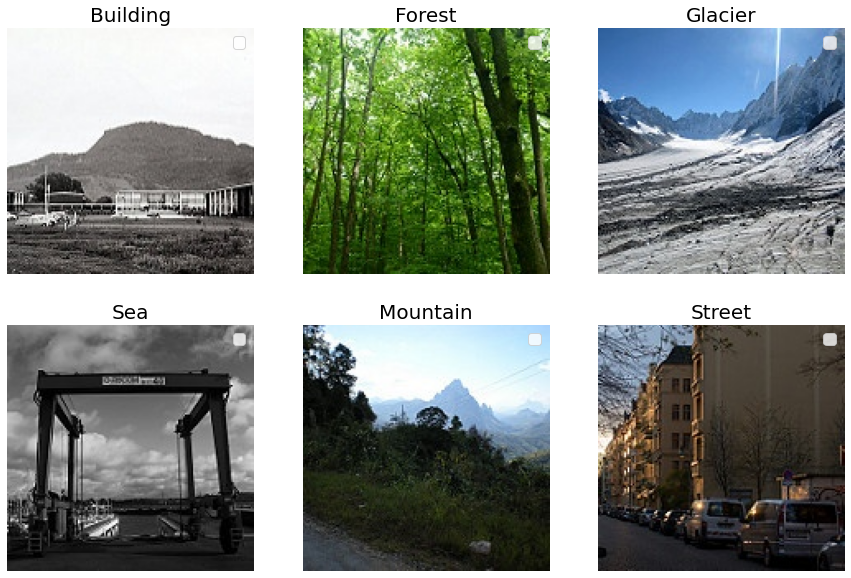

In [3]:
import matplotlib.image as img

building_image = img.imread(os.path.join(train_building_path, "0.jpg"))
forest_image = img.imread(os.path.join(train_forest_path, "8.jpg"))
glacier_image = img.imread(os.path.join(train_glacier_path, "10.jpg"))
sea_image = img.imread(os.path.join(train_sea_path, "1.jpg"))
mountain_image = img.imread(os.path.join(train_mountain_path, "16.jpg"))
street_image = img.imread(os.path.join(train_street_path, "2.jpg"))

fig, ax = plt.subplots(figsize=(15, 10), ncols=3, nrows=2)
ax[0,0].imshow(building_image)
make_pretty(ax[0,0], 'Building', img=True)
ax[0,1].imshow(forest_image)
make_pretty(ax[0,1], 'Forest', img=True)
ax[0,2].imshow(glacier_image)
make_pretty(ax[0,2], 'Glacier', img=True)
ax[1,0].imshow(sea_image)
make_pretty(ax[1,0], 'Sea', img=True)
ax[1,1].imshow(mountain_image)
make_pretty(ax[1,1], 'Mountain', img=True)
ax[1,2].imshow(street_image)
make_pretty(ax[1,2], 'Street', img=True)


### Shapes of the images

### Training image shapes

In [4]:
# Finds shape of every image in subdirectory
def find_shape(path):
    size = []
    print(f'Directories scanned:') 

    for folder in os.listdir(path):
        print(str(path + '/' + folder + '/*.jpg'))
        files = gb.glob(pathname=str(path +'/'+ folder + '/*.jpg'))
        for file in files: 
            image = plt.imread(file)
            size.append(image.shape)
    return pd.Series(size).value_counts()


find_shape(base_train_path)


Directories scanned:
/home/paganinik/intel_image/seg_train/seg_train/buildings/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/forest/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/glacier/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/mountain/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/sea/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/street/*.jpg


(150, 150, 3)    13986
(113, 150, 3)        7
(111, 150, 3)        3
(135, 150, 3)        3
(144, 150, 3)        2
(123, 150, 3)        2
(142, 150, 3)        2
(146, 150, 3)        2
(143, 150, 3)        2
(134, 150, 3)        2
(136, 150, 3)        2
(108, 150, 3)        2
(105, 150, 3)        1
(97, 150, 3)         1
(131, 150, 3)        1
(147, 150, 3)        1
(81, 150, 3)         1
(145, 150, 3)        1
(141, 150, 3)        1
(100, 150, 3)        1
(103, 150, 3)        1
(76, 150, 3)         1
(120, 150, 3)        1
(102, 150, 3)        1
(119, 150, 3)        1
(133, 150, 3)        1
(115, 150, 3)        1
(124, 150, 3)        1
(110, 150, 3)        1
(149, 150, 3)        1
(140, 150, 3)        1
dtype: int64

### Testing image shapes

In [5]:
find_shape(base_test_path)

Directories scanned:
/home/paganinik/intel_image/seg_test/seg_test/buildings/*.jpg
/home/paganinik/intel_image/seg_test/seg_test/forest/*.jpg
/home/paganinik/intel_image/seg_test/seg_test/glacier/*.jpg
/home/paganinik/intel_image/seg_test/seg_test/mountain/*.jpg
/home/paganinik/intel_image/seg_test/seg_test/sea/*.jpg
/home/paganinik/intel_image/seg_test/seg_test/street/*.jpg


(150, 150, 3)    2993
(141, 150, 3)       1
(110, 150, 3)       1
(76, 150, 3)        1
(149, 150, 3)       1
(72, 150, 3)        1
(131, 150, 3)       1
(81, 150, 3)        1
dtype: int64

### Prediction image shapes

In [6]:
size = []

files = gb.glob(pathname=str(base_pred_path + '/*.jpg'))
for file in files:
    image = plt.imread(file)
    size.append(image.shape)
    
        
        
pd.Series(size).value_counts()

(150, 150, 3)    7288
(133, 150, 3)       1
(139, 150, 3)       1
(108, 150, 3)       1
(124, 150, 3)       1
(131, 150, 3)       1
(144, 150, 3)       1
(149, 150, 3)       1
(143, 150, 3)       1
(129, 150, 3)       1
(100, 150, 3)       1
(112, 150, 3)       1
(126, 150, 3)       1
(374, 500, 3)       1
dtype: int64

### What do we do about these irregular shape? Do we just drop them?

### Finding max RGB values to know what the output shape should be


In [ ]:
#hi

### Preparing the data

For now we will keep the original image size. Lets see if Rosie can handle it


In [7]:
X_train = []
y_train = []

############################################
# Original size is 150, 150, 3
resample_x = 128
resample_y = 128
resample_z = 3
############################################
counter = 0
for folder in os.listdir(base_train_path):
    print(str(base_train_path + '/' + folder + '/*.jpg'))
    files = gb.glob(pathname=str(base_train_path +'/'+ folder + '/*.jpg'))
    for file in files: 
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ###########################################
        # interpolation could be changed too, just arbitrary right now
        image = cv2.resize(image,(resample_x,resample_y), interpolation=cv2.INTER_AREA)
        ###########################################
        X_train.append(image)
        y_train.append(counter)
    counter += 1

/home/paganinik/intel_image/seg_train/seg_train/buildings/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/forest/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/glacier/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/mountain/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/sea/*.jpg
/home/paganinik/intel_image/seg_train/seg_train/street/*.jpg


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Label: 1


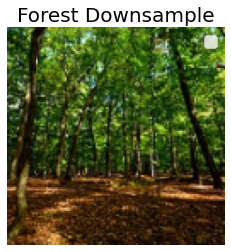

In [8]:
## Lets see what the downsampling did
fig, ax = plt.subplots()

ax.imshow(X_train[2500])
make_pretty(ax, 'Forest Downsample', img=True)
print(f'Label: {y_train[2500]}')

### Shuffling the data set

In [9]:

# For shuffling data set
X_train_full = np.asarray(X_train) / 255 # not sure if scaling is needed here
y_train_full = np.array(y_train)
indices = tf.range(start=0, limit=tf.shape(X_train_full)[0], dtype=tf.int32)
shuffled_indices = tf.random.shuffle(indices)
shuffled_X_train = tf.gather(X_train_full, shuffled_indices)
shuffled_y_train = tf.gather(y_train_full, shuffled_indices)
print(X_train_full[0:50])

2022-10-31 23:44:24.288639: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-31 23:44:24.830645: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13659 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


[[[[0.96862745 0.96862745 0.96078431]
   [0.96862745 0.96862745 0.96078431]
   [0.97254902 0.97254902 0.96470588]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  [[0.96470588 0.96470588 0.95686275]
   [0.96862745 0.96862745 0.96078431]
   [0.96862745 0.96862745 0.96078431]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  [[0.96470588 0.96470588 0.95686275]
   [0.96470588 0.96470588 0.95686275]
   [0.96862745 0.96862745 0.96078431]
   ...
   [0.97254902 0.97254902 0.97254902]
   [0.96862745 0.96862745 0.96470588]
   [0.96862745 0.96862745 0.96078431]]

  ...

  [[0.2        0.19607843 0.18823529]
   [0.22745098 0.22352941 0.21568627]
   [0.26666667 0.2627451  0.25490196]
   ...
   [0.25882353 0.23921569 0.22745098]
   [0.18431373 0.16470588 0.15294118]
   [0.25882353 0.23921569 0.22745098]]

  [[0.25882353 0.25490196 0.24705882]
   [0.1

### Train and validation split for training

In [10]:


X_train, X_valid = shuffled_X_train[:-1000], shuffled_X_train[-1000:]
y_train, y_valid = shuffled_y_train[:-1000], shuffled_y_train[-1000:]

print(f'X_train shape: {X_train.shape}')
print(f'X_train first sample shape: {X_train[0].shape}')
print(f'y_train shape: {y_train.shape}')
print(f'y_valid shape: {y_valid.shape}')






X_train shape: (13034, 128, 128, 3)
X_train first sample shape: (128, 128, 3)
y_train shape: (13034,)
y_valid shape: (1000,)


## Short rundown of the model of Autoencoders

Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but if we constrain networks in certain ways  
we can make this task a lot harder than copy and paste. One thing you could do is limit the size of the latent representations. One could also add noise   
tp the input of the model and ask the model to recreate the original image. Using these constraints, the model is forced to learn efficient ways of    
representing the data. In short, the coidngs are byproducts of the autoencoder learning the identity function under some constraints.     
(Not sure what identity function means)


Autoencoders are an unsupervised learning technique. This means they do not rely on labels to learn its weights. Instead, its output is compared to the original   
giving us our loss function. We can do pixel by pixel error and use that as the loss function.


Autoencoders are composed of a encoder (recognition) network, that encodes the inputs into a latent representation and a decoder (generative) network that decodes the latent representation   
hopefully close to its original form.


One interesting thing is that autoencoders resemble the architecture of a multi-layer perceptron. They also consist of an input that goes through a hidden layer and then is put    
through an output layer.

If the autoencoder uses multiple hidden layers, it is known as a deep autoencoder. Since autoencoders are very similar to neural networks they can be trained in the same fashion.   


The plan is to train a deep autoencoder to learn representations of the data. After that we will take of the decoding part of the model and replace it    
with a classification algorithm (TBD). 


Interestingly enough depending on what you want to achieve with your latent representation you can tune that layer. If you want to reduce features as much as possible so that you can   
feed those features to a classifier, you can choose a smaller latent representation, however you sacrifice the quality of the output. If you increase the size of the latent representation  
the model has more freedom to encode the image into the latent representation, making the output of the model more accurate. Tuning this layer you can find the balance you need between    
accuracy of output and dimensionality of the latent representation. This is why the latent representation layer is truly a hyperparameter of the model.


# I guess its model time

#### Arbitrary choices I made while setting up this problem


1. Scaling data between 0 and 1
2. Downsampling from 150, 150 to 100, 100
3. Layer sizes are arbitrary especially latent layer
4. Optimizer
5. activation function for each
6. loss function
7. Could try out different layers --> Conv2D


In [11]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

# Encoder network
# Shape to start is 100, 100, 3 so: 30000
# Latent layer with 512 is a hyperparameter that size can change
deep_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[resample_x, resample_y, resample_z]),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(1024, activation='sigmoid'),

])

# Decoder network
deep_decoder = keras.models.Sequential([
    keras.layers.Dense(2048, activation='relu'),
    keras.layers.Dense(4096, activation='relu'),
    keras.layers.Dense(resample_x* resample_y* resample_z, activation='sigmoid'),
    keras.layers.Reshape([resample_x, resample_y, resample_z])
])


# Putting it all together
deep_autoencoder = keras.models.Sequential([deep_encoder, deep_decoder])
# need pixel by pixel loss function here most likely
deep_autoencoder.compile(loss=tf.keras.losses.MeanSquaredError, optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), metrics=[rounded_accuracy])

In [12]:
deep_autoencoder.summary()
deep_autoencoder.build(input_shape=(None, resample_x, resample_y, resample_z))

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 1024)              211819520 
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       211867648 
                                                                 
Total params: 423,687,168
Trainable params: 423,687,168
Non-trainable params: 0
_________________________________________________________________


In [13]:
# why is it showing 408 instead of full size


# history = deep_autoencoder.fit(X_train, X_train, shuffle=True, batch_size=32, epochs=50, validation_data=(X_valid, X_valid))
# deep_autoencoder.save(os.path.join('models', 'model10312022_dense.h5'))

### making a new imrpoved model


In [14]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

data_augmentation_layer = keras.Sequential([                                    
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal',input_shape=(resample_x, resample_y, 3)),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.15),
  tf.keras.layers.experimental.preprocessing.RandomWidth(0.15),
  tf.keras.layers.experimental.preprocessing.RandomHeight(0.15),
], name='data_augmentation')

deep_e = keras.Sequential()
deep_e.add(keras.Input(shape=(128,128,3)))
deep_e.add(keras.layers.Conv2D(filters=32,kernel_size = (3, 3),strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())    
deep_e.add(keras.layers.Conv2D(filters=64,kernel_size = (3, 3),strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=128,kernel_size =(3, 3), strides=1,padding='same' ,activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=256,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.MaxPool2D())
deep_e.add(keras.layers.Conv2D(filters=512,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'))
deep_e.add(keras.layers.GlobalMaxPool2D())
deep_e.add(keras.layers.Dense(1024,activation='selu', kernel_initializer='lecun_normal'))



deep_d = keras.Sequential([
    keras.layers.Reshape((16, 16, 4)),
    keras.layers.Conv2D(filters=512,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=256,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=128,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.UpSampling2D(),
    keras.layers.Conv2D(filters=64,kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Conv2D(filters=32, kernel_size =(3, 3), strides=1,padding='same', activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.Conv2D(filters=3, kernel_size =(3, 3), strides=1,padding='same', activation='sigmoid'),
])

deep_ae = keras.models.Sequential([data_augmentation_layer, deep_e, deep_d])
deep_ae_no_augment = keras.models.Sequential([deep_e, deep_d])


deep_e.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])
deep_d.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])



deep_ae.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])
deep_ae_no_augment.compile(loss=tf.keras.losses.MeanSquaredError(), optimizer=tf.keras.optimizers.Adam(), metrics=[rounded_accuracy])

deep_ae.build(input_shape=(None, resample_x, resample_y, resample_z))
deep_ae_no_augment.build(input_shape=(None, resample_x, resample_y, resample_z))
deep_ae.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 sequential_3 (Sequential)   (None, 1024)              2093888   
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       1587011   
                                                                 
Total params: 3,680,899
Trainable params: 3,680,899
Non-trainable params: 0
_________________________________________________________________


In [15]:
deep_ae_no_augment.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_3 (Sequential)   (None, 1024)              2093888   
                                                                 
 sequential_4 (Sequential)   (None, 128, 128, 3)       1587011   
                                                                 
Total params: 3,680,899
Trainable params: 3,680,899
Non-trainable params: 0
_________________________________________________________________


In [16]:
data_augmentation_layer.summary()

Model: "data_augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 128, 128, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 128, 128, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 128, 128, 3)       0         
                                                                 
 random_width (RandomWidth)  (None, 128, None, 3)      0         
                                                                 
 random_height (RandomHeight  (None, None, None, 3)    0         
 )                                                               
                                                                 
Total params: 0
Trainable params: 0
Non-trainable

In [17]:

deep_d.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_1 (Reshape)         (None, 16, 16, 4)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 512)       18944     
                                                                 
 up_sampling2d (UpSampling2D  (None, 32, 32, 512)      0         
 )                                                               
                                                                 
 conv2d_6 (Conv2D)           (None, 32, 32, 256)       1179904   
                                                                 
 up_sampling2d_1 (UpSampling  (None, 64, 64, 256)      0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 128)      

In [18]:
deep_e.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 128)     

In [19]:

history_ae = deep_ae.fit(X_train, X_train, shuffle=True, batch_size=32, epochs=50, validation_data=(X_valid, X_valid))
deep_ae.save(os.path.join('models', 'model10312022_with_data_aug1.h5'))



Epoch 1/50


2022-10-31 23:44:35.295447: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


408/408 [==============================] - 129s 304ms/step - loss: 0.0464 - rounded_accuracy: 0.7510 - val_loss: 0.0330 - val_rounded_accuracy: 0.8016
Epoch 2/50
408/408 [==============================] - 95s 234ms/step - loss: 0.0318 - rounded_accuracy: 0.8003 - val_loss: 0.0333 - val_rounded_accuracy: 0.7930
Epoch 3/50
408/408 [==============================] - 88s 214ms/step - loss: 0.0304 - rounded_accuracy: 0.8068 - val_loss: 0.0291 - val_rounded_accuracy: 0.8170
Epoch 4/50
408/408 [==============================] - 83s 204ms/step - loss: 0.0298 - rounded_accuracy: 0.8093 - val_loss: 0.0293 - val_rounded_accuracy: 0.8142
Epoch 5/50
408/408 [==============================] - 81s 198ms/step - loss: 0.0294 - rounded_accuracy: 0.8117 - val_loss: 0.0290 - val_rounded_accuracy: 0.8167
Epoch 6/50
408/408 [==============================] - 79s 194ms/step - loss: 0.0293 - rounded_accuracy: 0.8120 - val_loss: 0.0283 - val_rounded_accuracy: 0.8204
Epoch 7/50
408/408 [========================

In [20]:
history_ae_no_aug = deep_ae_no_augment.fit(X_train, X_train, shuffle=True, batch_size=32, epochs=50, validation_data=(X_valid, X_valid))
deep_ae_no_augment.save(os.path.join('models', 'model10312022_no_data_aug1.h5'))

Epoch 1/50
408/408 [==============================] - 69s 167ms/step - loss: 0.0203 - rounded_accuracy: 0.8531 - val_loss: 0.0189 - val_rounded_accuracy: 0.8614
Epoch 2/50
408/408 [==============================] - 68s 167ms/step - loss: 0.0173 - rounded_accuracy: 0.8676 - val_loss: 0.0174 - val_rounded_accuracy: 0.8695
Epoch 3/50
408/408 [==============================] - 68s 167ms/step - loss: 0.0162 - rounded_accuracy: 0.8731 - val_loss: 0.0166 - val_rounded_accuracy: 0.8732
Epoch 4/50
408/408 [==============================] - 68s 167ms/step - loss: 0.0154 - rounded_accuracy: 0.8771 - val_loss: 0.0158 - val_rounded_accuracy: 0.8775
Epoch 5/50
408/408 [==============================] - 68s 167ms/step - loss: 0.0149 - rounded_accuracy: 0.8801 - val_loss: 0.0156 - val_rounded_accuracy: 0.8782
Epoch 6/50
408/408 [==============================] - 68s 167ms/step - loss: 0.0145 - rounded_accuracy: 0.8821 - val_loss: 0.0150 - val_rounded_accuracy: 0.8819
Epoch 7/50
408/408 [==============

In [21]:
history_ae.history

{'loss': [0.046414680778980255,
  0.031814947724342346,
  0.030375191941857338,
  0.029818769544363022,
  0.02935194969177246,
  0.029314640909433365,
  0.02886900305747986,
  0.028697311878204346,
  0.028612643480300903,
  0.028537379577755928,
  0.02850433811545372,
  0.028151260688900948,
  0.02814490720629692,
  0.027884364128112793,
  0.02786681428551674,
  0.027724597603082657,
  0.027706319466233253,
  0.027597540989518166,
  0.027410056442022324,
  0.027469726279377937,
  0.027245456352829933,
  0.027247348800301552,
  0.027097970247268677,
  0.02705685980618,
  0.027038732543587685,
  0.026988591998815536,
  0.02679954655468464,
  0.02690153382718563,
  0.026850270107388496,
  0.026840757578611374,
  0.026661435142159462,
  0.026558557525277138,
  0.026627622544765472,
  0.026521600782871246,
  0.026434361934661865,
  0.026559986174106598,
  0.02643171139061451,
  0.026266533881425858,
  0.026342162862420082,
  0.02627512440085411,
  0.0263233445584774,
  0.026141220703721046,

In [22]:
history_ae_no_aug.history

{'loss': [0.02028275839984417,
  0.017258295789361,
  0.01617882028222084,
  0.015417640097439289,
  0.014855001121759415,
  0.014451543800532818,
  0.014100474305450916,
  0.013803764246404171,
  0.013571846298873425,
  0.013340361416339874,
  0.01313836220651865,
  0.01293829083442688,
  0.01278352178633213,
  0.012661960907280445,
  0.01252972986549139,
  0.012429380789399147,
  0.01230434700846672,
  0.012275897897779942,
  0.01210626307874918,
  0.012023089453577995,
  0.011927167885005474,
  0.011811898089945316,
  0.011789252981543541,
  0.0117344930768013,
  0.01168029848486185,
  0.011570291593670845,
  0.011568630114197731,
  0.011427744291722775,
  0.011493428610265255,
  0.011332348920404911,
  0.01132877729833126,
  0.011278574354946613,
  0.011235913261771202,
  0.011178603395819664,
  0.011129600927233696,
  0.011062421835958958,
  0.011066396720707417,
  0.010999244637787342,
  0.010985388420522213,
  0.010946996510028839,
  0.01090907771140337,
  0.010851231403648853,


1/1 [==============================] - 0s 179ms/step


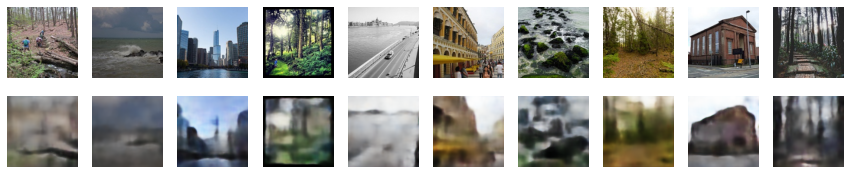

In [23]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=10):
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
        
def show_recon(model, images=X_valid, n_images=5):
    reconstructions = model.predict(images[:n_images])
    fig, ax = plt.subplot(figsize=(15, 10))
    for i in range(n_images):
        plt.subplot()        

        
deep_ae_no_aug = keras.models.Sequential([deep_e, deep_d])
show_reconstructions(deep_ae_no_aug, images=X_valid, n_images=10)

1/1 [==============================] - 0s 105ms/step


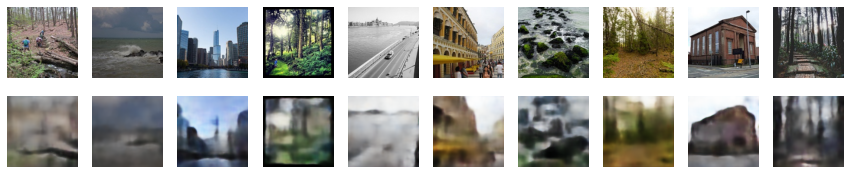

In [24]:
show_reconstructions(deep_ae_no_augment, images=X_valid, n_images=10)

### Seeing how good the latent representation is

In [ ]:
from sklearn.decomposition import PCA
comp = 4
pca = PCA(n_components=comp)
vals = pca.fit_transform(prepped_x, y_valid)
cols = [f'col_{n}' for n in range(comp) ]

df = pd.DataFrame(data = vals, columns=cols)

df.insert(comp, 'target', y_valid, True)


df.head()

In [ ]:
sns.pairplot(df, hue='target')

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

X_train_compressed = deep_e.predict(X_train)
prepped_train_x = X_train_compressed.reshape(13034, 1024)
X_valid_compressed = deep_e.predict(X_valid)
prepped_val_x = X_valid_compressed.reshape(1000, 1024)

knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(prepped_train_x, y_train)



In [ ]:
from sklearn.metrics import accuracy_score

pred = knn.predict(prepped_val_x)

acc = accuracy_score(pred, y_valid)

In [ ]:
acc
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_mat = confusion_matrix(y_valid, pred)

cm_display = ConfusionMatrixDisplay(conf_mat)

cm_display.plot()
plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

X_train_compressed = deep_e.predict(X_train)
X_train_compressed.shape
prepped_train_x = X_train_compressed.reshape(13034, 1024)

X_valid_compressed = deep_e.predict(X_valid)
prepped_val_x = X_valid_compressed.reshape(1000, 1024)



ran_for_clas = RandomForestClassifier(max_depth=5)

ran_for_clas.fit(prepped_train_x, y_train)

pred = ran_for_clas.predict(prepped_val_x)

print(accuracy_score(pred, y_valid))



conf_mat = confusion_matrix(y_valid, pred)

cm_display = ConfusionMatrixDisplay(conf_mat)

cm_display.plot()
plt.show()

In [ ]:
accuracy_score(pred, y_valid)

One thing I tried out was seeing whether data augmentation would improve the model performance. I used the same model, but on one of them I added a data augmentation layer. The accuracy of the model without data augmentation was 9% better. However when it came to using the latent representation as features in a classification problem, the model with data augmentation was superior (by about 7%) in both KNN and RandomForest models.

Things to try:
Different kernel sizes   
more / less data augmentation   
16 / 32 layers   
attention mechanisms   
distort the image input and recreate it    
   
For presentation:   
explore latent space   
Find a three d way of representing the data   